In [38]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import simpy
from LEOEnvironmentRL import initialize, load_route_from_csv  # Use RL version
import pandas as pd
import os
from stable_baselines3 import DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
import torch
import random

# %% 
import sb3_contrib
from HandoverEnvironment import LEOEnv as LEOEnvPPO 
from HandoverEnvironment import mask_fn, predict_valid_action
from HandoverEnvironment_DQN import LEOEnv as LEOEnvDQN
from HandoverEnvironment_DQN import predict_valid_action as predict_valid_action_dqn
from HandoverEnvironment_ODT import LEOEnv as LEOEnvODT
from HandoverEnvironment_ODT import predict_valid_action_dt
from ODT import OnlineDecisionTransformer
from LEOEnvironment import LEOEnv as LEOEnvBase

In [39]:
# Load observations from csv file 
obs_base_list = pd.read_csv('BASELINE_observations.csv').values
obs_dqn_list = pd.read_csv('DQN_observations.csv').values
obs_ppo_list = pd.read_csv('PPO_observations.csv').values
obs_odt_list = pd.read_csv('ODT_observations.csv').values
obs_odt_multiband_list = pd.read_csv('ODT_MULTIBAND_observations.csv').values

# Check data types
print("Data type:", type(obs_base_list[0,0]))
print("Sample values:", obs_base_list[0,:3])

Data type: <class 'numpy.float64'>
Sample values: [  0.          29.95526886 -95.33474731]


In [40]:
obs_base_list = np.array(obs_base_list)
obs_dqn_list = np.array(obs_dqn_list)    
obs_ppo_list = np.array(obs_ppo_list)
obs_odt_list = np.array(obs_odt_list)
obs_odt_multiband_list = np.array(obs_odt_multiband_list)

In [41]:
obs_dqn_list
print(len(obs_base_list))
print(len(obs_dqn_list))
print(len(obs_ppo_list))
print(len(obs_odt_list))
print(len(obs_odt_multiband_list))

3492
3666
6909
4227
3666


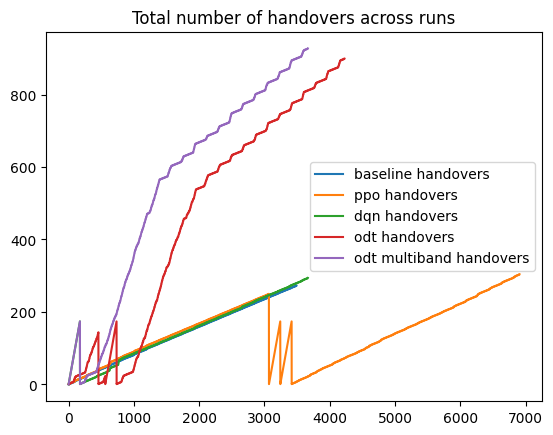

In [42]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 6], label = 'baseline handovers')
plt.plot(obs_ppo_list[:, 6], label = 'ppo handovers')
plt.plot(obs_dqn_list[:, 6],  label = 'dqn handovers')
plt.plot(obs_odt_list[:, 6], label = 'odt handovers')
plt.plot(obs_odt_multiband_list[:, 6], label = 'odt multiband handovers')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Total number of handovers across runs')
plt.show()

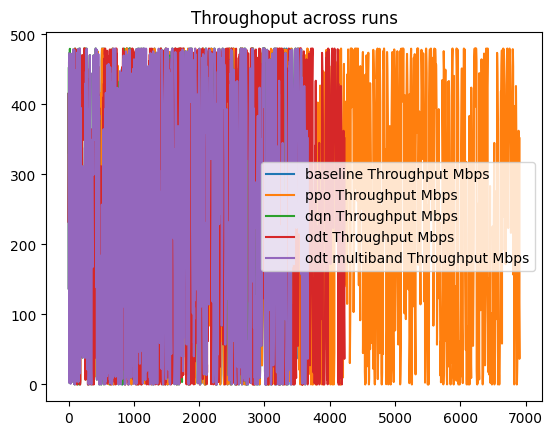

In [43]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 13], label = 'baseline Throughput Mbps')
plt.plot(obs_ppo_list[:, 13], label = 'ppo Throughput Mbps')
plt.plot(obs_dqn_list[:, 13],  label = 'dqn Throughput Mbps')
plt.plot(obs_odt_list[:, 13], label = 'odt Throughput Mbps')
plt.plot(obs_odt_multiband_list[:, 13], label = 'odt multiband Throughput Mbps')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Throughoput across runs')
plt.show()

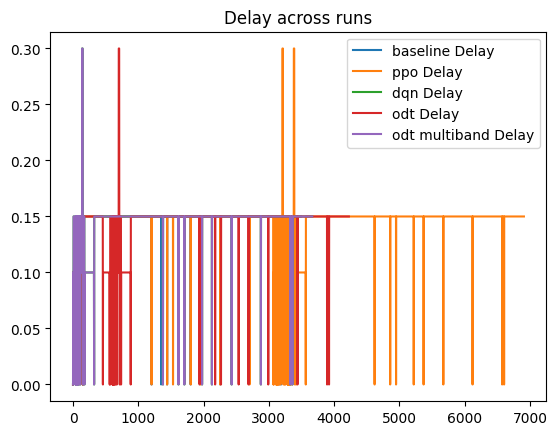

In [44]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 14], label = 'baseline Delay')
plt.plot(obs_ppo_list[:, 14], label = 'ppo Delay')
plt.plot(obs_dqn_list[:, 14],  label = 'dqn Delay')
plt.plot(obs_odt_list[:, 14], label = 'odt Delay')
plt.plot(obs_odt_multiband_list[:, 14], label = 'odt multiband Delay')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Delay across runs')
plt.show()

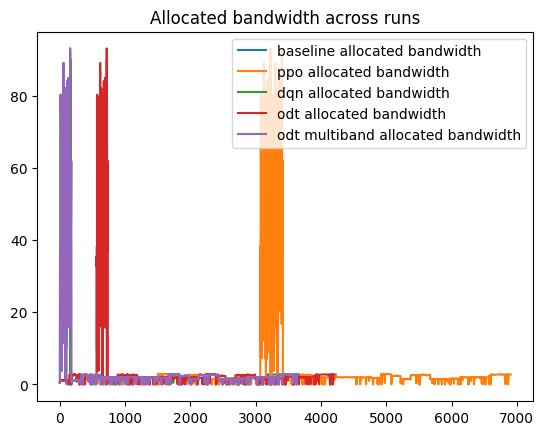

In [45]:
plt.plot(obs_base_list[:, 7], label = 'baseline allocated bandwidth')
plt.plot(obs_ppo_list[:, 7], label = 'ppo allocated bandwidth')
plt.plot(obs_dqn_list[:, 7], label = 'dqn allocated bandwidth')
plt.plot(obs_odt_list[:, 7], label = 'odt allocated bandwidth')
plt.plot(obs_odt_multiband_list[:, 7], label = 'odt multiband allocated bandwidth')
plt.legend()
plt.title('Allocated bandwidth across runs')
plt.show()

In [46]:
# Get average allocation to demand across runs 
avg_allocated_to_demand_base = []
avg_allocated_to_demand_ppo = []
avg_allocated_to_demand_dqn = []
avg_allocated_to_demand_odt = []
avg_allocated_to_demand_odt_multiband = []

for i in range(len(obs_base_list)): 
    avg_allocated_to_demand_base.append(np.mean(obs_base_list[:i, 8]))
    avg_allocated_to_demand_ppo.append(np.mean(obs_ppo_list[:i, 8]))
    avg_allocated_to_demand_dqn.append(np.mean(obs_dqn_list[:i, 8]))
    avg_allocated_to_demand_odt.append(np.mean(obs_odt_list[:i, 8]))
    avg_allocated_to_demand_odt_multiband.append(np.mean(obs_odt_multiband_list[:i, 8]))

c:\Users\MO\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\MO\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


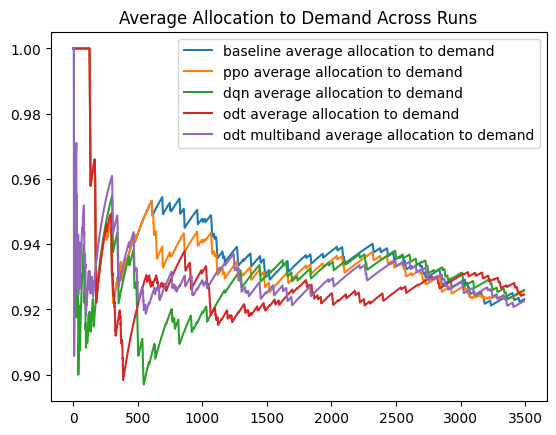

In [47]:
plt.plot(avg_allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(avg_allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(avg_allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.plot(avg_allocated_to_demand_odt, label = 'odt average allocation to demand')
plt.plot(avg_allocated_to_demand_odt_multiband, label = 'odt multiband average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()

In [48]:
# Average Allocation to demand 
print("Baseline Average Allocation to Demand: ", np.mean(obs_base_list[:, 8]))
print("PPO Average Allocation to Demand: ", np.mean(obs_ppo_list[:, 8]))
print("DQN Average Allocation to Demand: ", np.mean(obs_dqn_list[:, 8]))
print("ODT Average Allocation to Demand: ", np.mean(obs_odt_list[:, 8]))    
print("ODT MULTIBAND Average Allocation to Demand: ", np.mean(obs_odt_multiband_list[:, 8]))

Baseline Average Allocation to Demand:  0.923130011265869
PPO Average Allocation to Demand:  0.9232243880091543
DQN Average Allocation to Demand:  0.9265170707643984
ODT Average Allocation to Demand:  0.9222573464165417
ODT MULTIBAND Average Allocation to Demand:  0.9237996089856653


In [35]:
# Average throughput across runs
print("Baseline Average Throughput Mbps: ", np.mean(obs_base_list[:, 13]))
print("PPO Average Throughput Mbps: ", np.mean(obs_ppo_list[:, 13]))
print("DQN Average Throughput Mbps: ", np.mean(obs_dqn_list[:, 13]))
print("ODT Average Throughput Mbps: ", np.mean(obs_odt_list[:, 13]))
print("ODT MULTIBAND Average Throughput Mbps: ", np.mean(obs_odt_multiband_list[:, 13]))

Baseline Average Throughput Mbps:  233.7271235557273
PPO Average Throughput Mbps:  245.82385812711684
DQN Average Throughput Mbps:  244.48546752416027
ODT Average Throughput Mbps:  242.71232321721905
ODT MULTIBAND Average Throughput Mbps:  245.454444944986


In [36]:
# Average Delay across runs
print("Baseline Average Delay ms: ", np.mean(obs_base_list[:, 14]))
print("PPO Average Delay ms: ", np.mean(obs_ppo_list[:, 14]))
print("DQN Average Delay ms: ", np.mean(obs_dqn_list[:, 14]))
print("ODT Average Delay ms: ", np.mean(obs_odt_list[:, 14]))
print("ODT MULTIBAND Average Delay ms: ", np.mean(obs_odt_multiband_list[:, 14]))

Baseline Average Delay ms:  0.13382353418159712
PPO Average Delay ms:  0.14653351272536277
DQN Average Delay ms:  0.1466721279218394
ODT Average Delay ms:  0.14396735821170442
ODT MULTIBAND Average Delay ms:  0.1466721279218394


In [37]:
# Total Handovers 
print("Baseline Total Handovers: ", np.max(obs_base_list[:, 6]))
print("PPO Total Handovers: ", np.max(obs_ppo_list[:, 6]))
print("DQN Total Handovers: ", np.max(obs_dqn_list[:, 6]))
print("ODT Total Handovers: ", np.max(obs_odt_list[:, 6]))
print("ODT MULTIBAND Total Handovers: ", np.max(obs_odt_multiband_list[:, 6]))

Baseline Total Handovers:  173.0
PPO Total Handovers:  304.0
DQN Total Handovers:  294.0
ODT Total Handovers:  899.0
ODT MULTIBAND Total Handovers:  927.0
